# Loading data into pandas

In [3]:
import glob
import pandas
import os
import numpy
import re

## Combining single data files into one huge import file
Stripping of non body elements yield better performance with accuracy at the same level (TF/IDF benefited hugely due to reduced noise)
As per Panda docs, there is no penalty to concat multiple DataFrames after creation.

In [4]:
mergedDataFrame = pandas.DataFrame()
dataFramesList = []
frameIndex = 0
trainDatasetDirectory = '/Users/bumblebee/PycharmProjects/ClassifierForWebScraper/train-dataset'
for fileName in glob.iglob(trainDatasetDirectory + '**/*.data', recursive=True):
    fileHandle = open(fileName, 'r')
    lineNo1 = fileHandle.readline()
    lineNo2 = fileHandle.readline()
    documentLines = fileHandle.read()
    bodyStart = documentLines.find('<body>')
    bodyEnd = documentLines.find('</body>')
    result = documentLines
    if bodyStart != -1 and bodyEnd != -1:
        result = documentLines[bodyStart+6:bodyEnd]
    lvl0Category = lineNo1.split(" ")[0]
    dataFrameFromExample = pandas.DataFrame({'File Name' : os.path.basename(fileName), 
                                             'Raw Document' : result, 
                                             'LVL0 Category' : lvl0Category, 
                                            }, index=[frameIndex])
    dataFramesList.append(dataFrameFromExample)
    frameIndex += 1
    
mergedDataFrame = pandas.concat(dataFramesList)

# regexp to cut non body html proved to be way too slow, implemented in reading raw file part
def standardizeText(df, textField):
    # remove attributes from html
    attributesStrip = re.compile('<([a-z]+)[^>]*>', flags=re.MULTILINE|re.DOTALL)
    scriptRemoval  = re.compile('<script[^>]*>.*?</script>', flags=re.MULTILINE|re.DOTALL)
    commentsRemoval = re.compile('<!--.*?-->', flags=re.M|re.DOTALL)
    xmlPreambleRemoval = re.compile('<\?.*?\?>', flags=re.M|re.DOTALL)
    styleRemoval = re.compile('<style>.*?</style>', flags=re.M|re.DOTALL)
    #onlyBodyTrimBefore = re.compile('.*<body>', flags=re.M|re.DOTALL)
    #onlyBodyTrimAfter = re.compile('</body>.*', flags=re.M|re.DOTALL)

    df[textField] = df[textField].str.lower()
    #df[textField] = df[textField].str.replace(onlyBodyTrimBefore, '')
    #df[textField] = df[textField].str.replace(onlyBodyTrimAfter, '')
    df[textField] = df[textField].str.replace(attributesStrip, r"<\1>")
    df[textField] = df[textField].str.replace(scriptRemoval, '')
    df[textField] = df[textField].str.replace(commentsRemoval, '')
    df[textField] = df[textField].str.replace(xmlPreambleRemoval, '')
    df[textField] = df[textField].str.replace(styleRemoval, '')
    # get rid of markup 
    df[textField] = df[textField].str.replace(r'<[^>]+>', '')
    df[textField] = df[textField].str.replace('</[^>]+>', '')
    # some high frequency html entities
    df[textField] = df[textField].str.replace(r'&oacute;', 'ó')
    df[textField] = df[textField].str.replace(r'&nbsp;', ' ')
    df[textField] = df[textField].str.replace(r'&raquo;', '')
    df[textField] = df[textField].str.replace(r'&quot;', '')
    # TODO: use beautiful soup to handle html entities
    #df[textField] = df[textField].str.replace('<link>', '')
    #df[textField] = df[textField].str.replace('</link>', '')
    #df[textField] = df[textField].str.replace('<meta>', '')
    #df[textField] = df[textField].str.replace('</meta>', '')
    #df[textField] = df[textField].str.replace('<head>', '')
    #df[textField] = df[textField].str.replace('</head>', '')

    return df

mergedDataFrame = standardizeText(mergedDataFrame, "Raw Document")


In [5]:
mergedDataFrame.head()

,File Name,LVL0 Category,Raw Document
0,2httpengraveplblog.data,OTHER_TEXT_CONTENT,\n\n\n\n\n\n\n\n\nblog o nieśmiertelnikach i m...
1,2httpgrynaprzegladarkenetgamegrepolis.data,NO_CONTENT,\n\n \n \n \n \n ...
2,2httplpdrakensangcomlplightspellweaveranimatio...,NO_CONTENT,\n\n\n \n \n \n \n ...
3,2httplploacomlpmainaidaiptgoplutmsourcemediaut...,NO_CONTENT,\n\n\n \n \n \n ...
4,2httppldarkorbitbigpointcomaidaiputmsourceaffi...,NO_CONTENT,\n \n \n uruchom javascript w swojej ...


### Assiging numerical values to output categories

In [6]:
mergedDataFrame['Class Label'] = numpy.where(mergedDataFrame['LVL0 Category'] == 'HIGH_QUALITY_CONTENT', 0, 
                                    numpy.where(mergedDataFrame['LVL0 Category'] == 'FORUM', 1, 
                                      numpy.where(mergedDataFrame['LVL0 Category'] == 'OTHER_TEXT_CONTENT', 2, 
                                        numpy.where(mergedDataFrame['LVL0 Category'] == 'OTHER_MULTIMEDIA_CONTENT', 3, 
                                            numpy.where(mergedDataFrame['LVL0 Category'] == 'NO_CONTENT', 4, 5
                                              #numpy.where(mergedDataFrame['LVL0 Category'] == 'UNKNOWN', 6, 0 
                                            )))))

mergedDataFrame['Class Label'][:10]

0    2
1    4
2    4
3    4
4    4
5    0
6    4
7    4
8    3
9    3
Name: Class Label, dtype: int64

In [7]:
mergedDataFrame.describe()

,Class Label
count,710.000000
mean,1.980282
std,1.460203
min,0.000000
25%,0.000000
50%,2.000000
75%,3.000000
max,4.000000


In [8]:
mergedDataFrame.groupby('Class Label').count()

,File Name,LVL0 Category,Raw Document
Class Label,,,
0,194,194,194
1,64,64,64
2,131,131,131
3,204,204,204
4,117,117,117


In [9]:
mergedDataFrame.to_csv('/Users/bumblebee/PycharmProjects/ClassifierForWebScraper/cleaned-train-dataset.csv')

In [10]:
# testing multiline and dot matches newline regexp
toReplace = "<script>\n fdaf fdsaf \n fdas  \n </script>"
print(toReplace)
scriptRemoval  = re.compile('<script[^>]*>.*?</script>', flags=re.MULTILINE|re.DOTALL)
replaced  = re.sub(scriptRemoval, '<script></script>', toReplace)
print(replaced)

<script>
 fdaf fdsaf 
 fdas  
 </script>
<script></script>


### Split data 75% for training and 25% for testing

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mergedDataFrame['Raw Document'], 
                                                    mergedDataFrame['Class Label'], 
                                                    random_state=0)

In [12]:
print('X_train first entry:\n\n', X_train.iloc[0][0:200])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry:

 

    
        dzieci kąpały się w bałtyku mimo zakazów. dwie dziewczynki zaginęły - fakty ekstra tvn
        
                    
        
        

            
    
    
        
        

    
  


X_train shape:  (532,)


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer().fit(X_train)

vect


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [14]:
len(vect.get_feature_names())

68980

In [15]:
vect.get_feature_names()[::1000]

['00',
 '16xtradebdm',
 '27jaki',
 '418',
 '750d',
 'afcanon',
 'antenę',
 'badaczy',
 'biegambolubię',
 'brodzikikabinybrodzikiwanny',
 'ccenergy',
 'citeulike',
 'cznej',
 'dhadecw_klis09__6',
 'dotyczyły',
 'dziklispiżmakjenot',
 'epopeją',
 'finansowym',
 'gant',
 'gral',
 'heftig',
 'indusów',
 'janoszka',
 'kappa',
 'knights',
 'korkach',
 'kucharze',
 'lepszą',
 'lęk',
 'małogoszcz',
 'miodu',
 'muruje',
 'nanovo',
 'niedźwiedzia',
 'nowina',
 'oddziaływanie',
 'określa',
 'ostrzega',
 'password',
 'pisklę',
 'podkrzywdzie',
 'pomieścić',
 'powiatowa',
 'primamoda',
 'przejmujące',
 'przyniosły',
 'quench',
 'reprezentatywnym',
 'rozproszone',
 'samorząd',
 'siedzące',
 'sointeractive',
 'spływ',
 'stłuczki',
 'sznurki',
 'teledysk',
 'trendingtrending',
 'uciąć',
 'urzędowych',
 'wachowicz',
 'wiekiem',
 'wpłynąć',
 'wyjechalam',
 'wytrzyma',
 'zac',
 'zapewniam',
 'zbrodnia',
 'znajoma',
 'łazienkowy']

In [16]:
X_train_vectorized = vect.transform(X_train)

X_train_vectorized

<532x68980 sparse matrix of type '<class 'numpy.int64'>'
	with 233550 stored elements in Compressed Sparse Row format>

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(X_train_vectorized, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

### Accuracy = number of correct predictions / Total number of predictions

In [18]:
from sklearn.metrics import accuracy_score

predictions = classifier.predict(vect.transform(X_test))

accuracy = accuracy_score(predictions, y_test)

print('accuracy: %s' % accuracy)

accuracy: 0.741573033708


### Need another metrics also, ie. precision (proportion of positive identifications that were correct - value of 1.0 for model that produces no false positives) and recall (proportion of actual positives that was identified correctly - model with no false negatives gives rate of 1.0) 

In [19]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(predictions, y_test, pos_label=None, average='weighted')             

recall = recall_score(predictions, y_test, pos_label=None, average='weighted')

print('precision: %s, recall %s' % (precision, recall))

precision: 0.744693509887, recall 0.741573033708


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(min_df=5).fit(X_train)
len(vect.get_feature_names())

8881

In [21]:
X_train_vectorized = vect.transform(X_train)
classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(X_train_vectorized, y_train)

predictions = classifier.predict(vect.transform(X_test))

accuracy = accuracy_score(predictions, y_test)

print('accuracy: %s' % accuracy)

precision = precision_score(predictions, y_test, pos_label=None, average='weighted')             

recall = recall_score(predictions, y_test, pos_label=None, average='weighted')

print('precision: %s, recall %s' % (precision, recall))

accuracy: 0.634831460674
precision: 0.736868051343, recall 0.634831460674


In [22]:
feature_names = numpy.array(vect.get_feature_names())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['374' 'kochamy' 'porażkę' 'wta' 'letnich' 'ciekawie' 'poprzednich'
 'opiera' 'skończyć' 'niektórym']

Largest tfidf: 
['and' 'world' 'shy' 'amp' 'plotki' 'nf' 'wordpress' 'św' 'cb' 'images']


### TODO: a lot of stopwords there, need to get rid of them

In [23]:
sorted_coef_index = classifier.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['amp' '00' 'trwania' 'akcesoria' 'hasło' 'komentarzy' 'wyświetleń'
 'zaloguj' 'forum' 'zł']

Largest Coefs: 
['na' 'że' 'nie' 'rio' 'interia' 'to' 'pikio' 'si' 'komentarz' 'godz']


### TODO: Again, need to get rid of those na, że, to 

## Create bigram with minium count of 5 occurances

In [24]:
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)

X_train_vectorized = vect.transform(X_train)

len(vect.get_feature_names())

15245

In [25]:
classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(X_train_vectorized, y_train)

predictions = classifier.predict(vect.transform(X_test))

accuracy = accuracy_score(predictions, y_test)
precision = precision_score(predictions, y_test, pos_label=None, average='weighted')             
recall = recall_score(predictions, y_test, pos_label=None, average='weighted')

print('accuracy: %s, precision: %s, recall %s' % (accuracy, precision, recall))

accuracy: 0.741573033708, precision: 0.741567134839, recall 0.741573033708


In [26]:
import numpy as np
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt


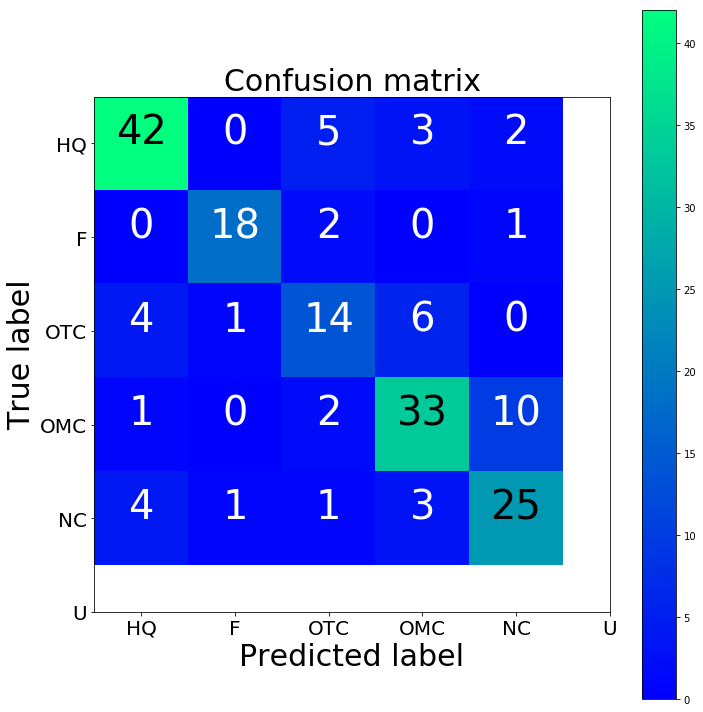

[[42  0  5  3  2]
 [ 0 18  2  0  1]
 [ 4  1 14  6  0]
 [ 1  0  2 33 10]
 [ 4  1  1  3 25]]


In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['HQ', 'F', 'OTC', 'OMC', 'NC', 'U'], 
                             normalize=False, title='Confusion matrix')
plt.show()
print(cm)


### TODO: problem with OTHER_MULTIMEDIA_CONTENT classified as NO_CONTENT (too much stripping?)

In [28]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes


### Print 10 most important features and 10 most irrelevant ones for each category

In [29]:
importance = get_most_important_features(vect, classifier, 10)
importance

{0: {'bottom': [(-0.30724583378223003, 'password'),
   (-0.31055772505396889, 'logowanie'),
   (-0.31244007920988803, 'logowania'),
   (-0.31765543660954992, 'back'),
   (-0.33842436625323541, 'hellip'),
   (-0.35766861009519196, 'world'),
   (-0.38683332558832195, 'strona'),
   (-0.39011829682941251, 'hasło'),
   (-0.44760273117799942, 'and'),
   (-0.55008767976067174, 'wordpress')],
  'tops': [(0.21449906860197085, 'ciała'),
   (0.21614796645019674, 'konferencji'),
   (0.21967729293373547, 'najlepszych'),
   (0.2271895998744923, 'prezent'),
   (0.24854330779741332, 'prywatności'),
   (0.24993792849545748, 'polityka prywatności'),
   (0.25353729857064689, 'wyłącz'),
   (0.25723935455357866, 'panel'),
   (0.27632450701435674, 'że'),
   (0.34962368239862907, 'użytkownika')]},
 1: {'bottom': [(-0.18423021196466396, 'polityka prywatności'),
   (-0.1870424109737672, 'błąd'),
   (-0.19715904896161812, 'hasło'),
   (-0.20158484267223342, 'nowe'),
   (-0.2159484312786519, 'panel'),
   (-0.221